## Installation

First install the OpenLLMTelemetry package along with LangGraph dependencies. In this example we will start with the LangGraph tutorial and walk through a simple example showing how we can integrate into some of the nodes with custom tracing as well as the automatic LLM tracing we get from OpenLLMTelemtry.

This example is adapted from example code here: https://python.langchain.com/v0.1/docs/langgraph/ where you might want to try this approach with more complex examples.

In [ ]:
pip install -qU openllmtelemetry[openai] langgraph langchain_openai langchain_community tavily-python

In [ ]:
import os

os.environ["WHYLABS_API_KEY"] = "replace-with-whylabs-api-key"
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = "replace-with-model-id" #
os.environ["OPENAI_API_KEY"] = ""  # This example assumes you have an OpenAI key already set

In [ ]:
import openllmtelemetry

tracer = openllmtelemetry.instrument()

In [4]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessageGraph

# openllmtelemetry automatically instruments LLM calls like the ChatOpenAI
model = ChatOpenAI(temperature=0)

graph = MessageGraph()

graph.add_node("oracle", model) # type: ignore
graph.add_edge("oracle", END)

graph.set_entry_point("oracle")

runnable = graph.compile()

In [5]:
runnable.invoke(HumanMessage("What is 1 + 1?")) # type: ignore

[HumanMessage(content='What is 1 + 1?', id='e24d529d-8476-446f-829d-4bd381dfbb89'),
 AIMessage(content='1 + 1 equals 2.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-f992ec29-7e87-4165-ab86-6d579a96265a-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23})]

In [6]:
with tracer.start_as_current_span("LangGraph-test-invoke") as span: # pyright: ignore[reportUnknownVariableType,reportUnknownMemberType]
    span.set_attribute("category", "math")  # pyright: ignore[reportUnknownMemberType]
    result = runnable.invoke(HumanMessage("What is 1 + 1?"))  # pyright: ignore[reportUnknownMemberType,reportUnknownVariableType]

result

[HumanMessage(content='What is 1 + 1?', id='ee924f52-a178-4ce2-8b3c-b4a657f48de3'),
 AIMessage(content='1 + 1 equals 2.', response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 15, 'total_tokens': 23}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-1c13dd81-365d-4d69-bb0a-8ebc7710c694-0', usage_metadata={'input_tokens': 15, 'output_tokens': 8, 'total_tokens': 23})]

In [7]:
from typing import Optional

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def multiply(first_number: int, second_number: int):
    """Multiplies two numbers together."""
    tracer: Optional[Tracer] = openllmtelemetry.get_tracer()
    with tracer.start_as_current_span("tool-multiply") as span:  # pyright: ignore[reportOptionalMemberAccess]
        result = first_number * second_number
        span.set_attribute("first_number", first_number)
        span.set_attribute("second_number", second_number)
        span.set_attribute("result", result)
        return result

model = ChatOpenAI(temperature=0)
model_with_tools = model.bind_tools([multiply])  # pyright: ignore[reportUnknownMemberType]

builder = MessageGraph()

builder.add_node("oracle", model_with_tools)  # pyright: ignore[reportUnknownMemberType]

tool_node = ToolNode([multiply])  # pyright: ignore[reportArgumentType]
builder.add_node("multiply", tool_node)  # pyright: ignore[reportUnknownMemberType]
builder.add_edge("multiply", END)
builder.set_entry_point("oracle")

In [8]:
from typing import List, Literal

from langchain_core.messages import BaseMessage


def router(state: List[BaseMessage]) -> Literal["multiply", "__end__"]:
    tracer = openllmtelemetry.get_tracer()
    with tracer.start_as_current_span("router") as span:  # pyright: ignore[reportUnknownVariableType,reportUnknownMemberType,reportOptionalMemberAccess]
        tool_calls = state[-1].additional_kwargs.get("tool_calls", [])  # pyright: ignore[reportUnknownMemberType, reportUnknownVariableType]
        tool_call_len = len(tool_calls)  # type: ignore
        span.set_attribute("len_tool_calls", tool_call_len)
        if tool_call_len:
            span.set_attribute("route-next", "multiply")
            return "multiply"
        else:
            span.set_attribute("route-next", "__end__")
            return "__end__"

builder.add_conditional_edges("oracle", router)

In [9]:
runnable = builder.compile()

def invoke_with_trace(message: str):
    with tracer.start_as_current_span("graph-invoke"):  # type: ignore
        result = runnable.invoke(HumanMessage(message))  # type: ignore
    return result

Now lets test out a control flow where we expect a the multiply tool

In [10]:
invoke_with_trace("What is 123 * 456?")

[HumanMessage(content='What is 123 * 456?', id='98be3eb8-7ab3-469f-8422-a5835d574403'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JNAkQcQsCXKICIvassOLrntz', 'function': {'arguments': '{"first_number":123,"second_number":456}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6d6dbe69-9a43-4eda-95a8-55d4a907a863-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 123, 'second_number': 456}, 'id': 'call_JNAkQcQsCXKICIvassOLrntz'}], usage_metadata={'input_tokens': 57, 'output_tokens': 19, 'total_tokens': 76}),
 ToolMessage(content='56088', name='multiply', id='83e41e10-750c-4d30-85fb-c9cfd952ffd8', tool_call_id='call_JNAkQcQsCXKICIvassOLrntz')]

Let's also try a scenario without a multiplication request to see if the other route of the conditional works so we have traces for each of these scenarios.

In [11]:
invoke_with_trace("Can penguins fly?")

[HumanMessage(content='Can penguins fly?', id='b7ddcdb1-a86d-4930-8d2b-867a29851f76'),
 AIMessage(content='Penguins are flightless birds and are not able to fly. They have adapted to swim underwater instead of flying in the air.', response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 54, 'total_tokens': 81}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-27b3eb42-a84d-4d3f-b619-f002f18facdc-0', usage_metadata={'input_tokens': 54, 'output_tokens': 27, 'total_tokens': 81})]

## Visualizing the Graph

You can use the graph to get a png to help understand the possible control flow through your graph.

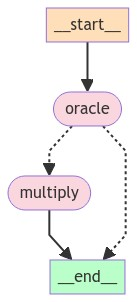

In [12]:
from IPython.display import Image, display  # type: ignore
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Viewing the traces

Then in WhyLabs with LLM Secure you can view your captured traces and telemetry for this graph including your guardrailed LLM calls, and it will look something like this:

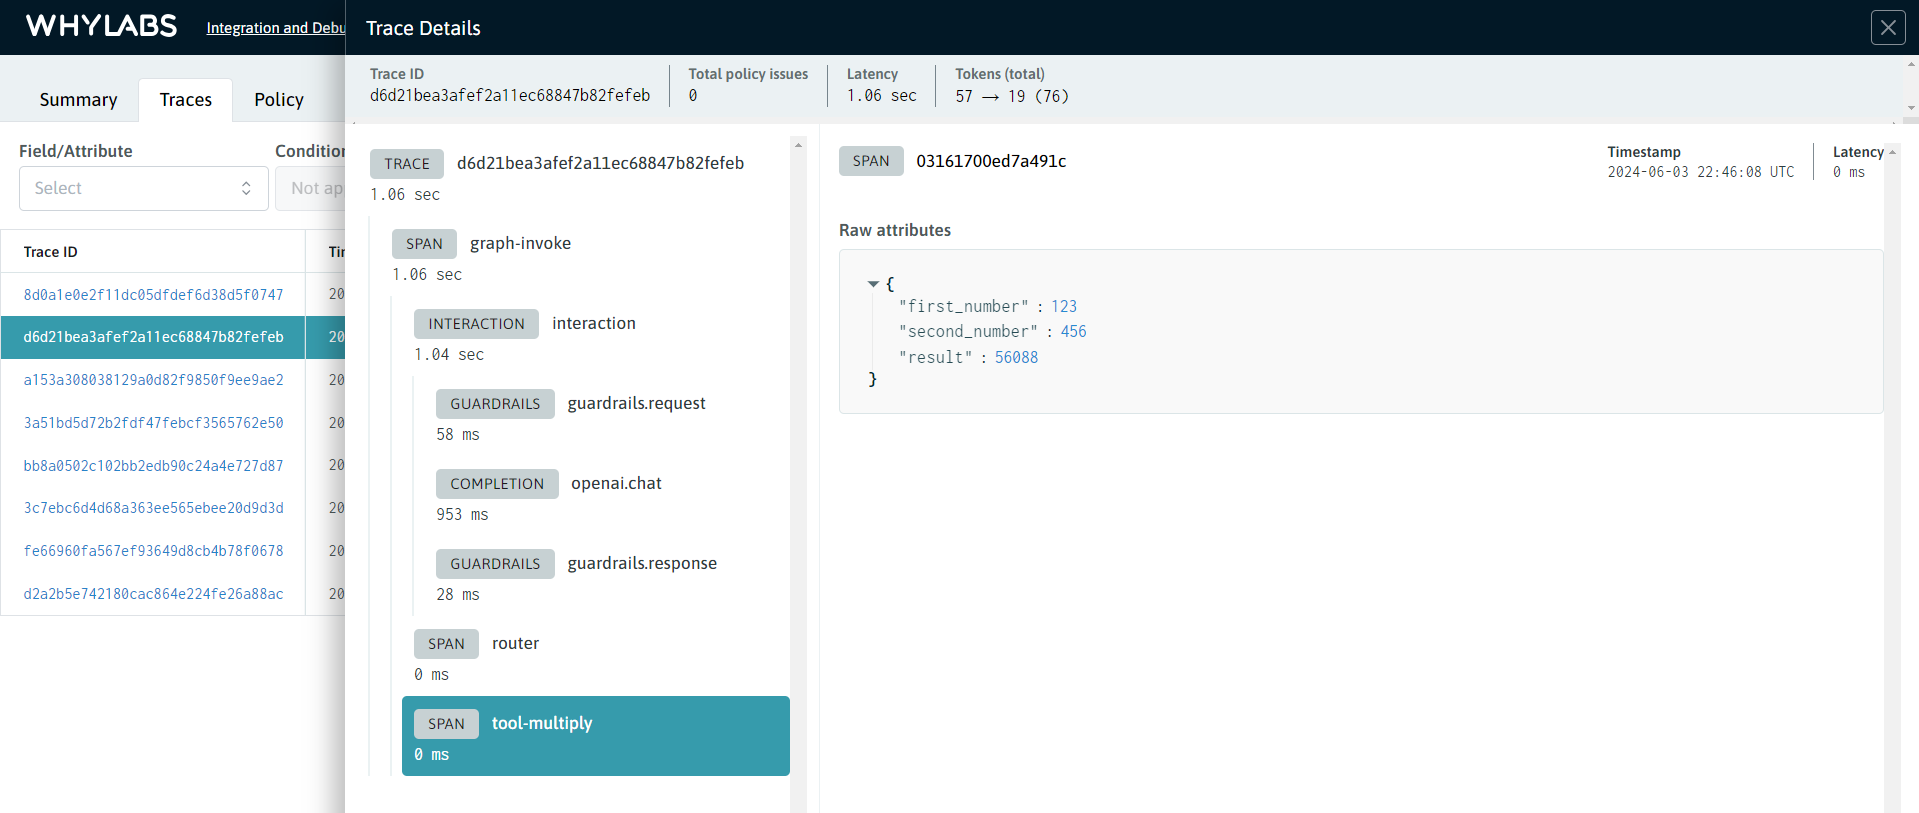